In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import torch
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)     # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full column width
ddi_path = 'data/ddi.csv'
db_smiles_path = 'data/db_smiles.csv'

In [3]:
"""
The data provided by DrugBank is given in the format of XML so we need to first read and parse the .xml file to extract the 
relevant information to DDI.
"""

def process_drugbank_to_dataframe(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'ns': 'http://www.drugbank.ca'}
    data = []
    for drug in root.findall('ns:drug', namespace):
        primary_id = None
        for drugbank_id in drug.findall('ns:drugbank-id', namespace):
            # We take primary drugbank-id as our 1st Drug ID because it is in the correct format to be mapped to BindingDB
            if drugbank_id.attrib.get('primary') == 'true': 
                primary_id = drugbank_id.text
                break

        # If no primary ID is found, skip this drug entry
        if not primary_id:
            continue

        # Extract name and description
        name = drug.find('ns:name', namespace)
        description = drug.find('ns:description', namespace)
        primary_name = name.text if name is not None else 'N/A'
        primary_description = description.text if description is not None else 'N/A'

        # For each drug there is a list of drug-interaction pairings each with different description
        interactions = drug.find('ns:drug-interactions', namespace)

        # We skip drug entries that have no DDI records
        if interactions:
            for interaction in interactions.findall('ns:drug-interaction', namespace):
                interacting_drug_id = interaction.find('ns:drugbank-id', namespace).text
                interacting_drug_name = interaction.find('ns:name', namespace).text
                interaction_description = interaction.find('ns:description', namespace).text

                data.append({
                    'primary_id': primary_id,
                    'primary_name': primary_name,
                    'primary_description': primary_description,
                    'interacting_drug_id': interacting_drug_id,
                    'interacting_drug_name': interacting_drug_name,
                    'interaction_description': interaction_description
                })

    df = pd.DataFrame(data)
    multi_index_df = df.set_index(['primary_id', 'interacting_drug_id'])

    return multi_index_df

file_path = 'data/drugbank.xml'
ddi = process_drugbank_to_dataframe(file_path)
ddi = ddi.reset_index()

In [4]:
ddi[(ddi['primary_id'] == ddi.iloc[0]['interacting_drug_id'])]

,primary_id,interacting_drug_id,primary_name,primary_description,interacting_drug_name,interaction_description
1580646,DB06605,DB00001,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Lepirudin,Apixaban may increase the anticoagulant activities of Lepirudin.
1580647,DB06605,DB00006,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Bivalirudin,Apixaban may increase the anticoagulant activities of Bivalirudin.
1580648,DB06605,DB00009,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Alteplase,Apixaban may increase the anticoagulant activities of Alteplase.
1580649,DB06605,DB00013,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Urokinase,Apixaban may increase the anticoagulant activities of Urokinase.
1580650,DB06605,DB00015,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Reteplase,Apixaban may increase the anticoagulant activities of Reteplase.
...,...,...,...,...,...,...
1581890,DB06605,DB11679,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Fruquintinib,The metabolism of Fruquintinib can be decreased when combined with Apixaban.
1581891,DB06605,DB12005,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Nirogacestat,The serum concentration of Apixaban can be increased when it is combined with Nirogacestat.
1581892,DB06605,DB16200,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of both free and bound FXa, as well as prothrombinase, independent of antithrombin III for the prevention and treatment of thromboembolic diseases[Label,A6897]. It is marketed under the name Eliquis[Label,L6043]. Apixaban was approved by the FDA on December 28, 2012[L6043].",Iptacopan,The metabolism of Iptacopan can be decreased when combined with Apixaban.
1581893,DB06605,DB14713,Apixaban,"Apixaban is an oral, direct, and highly selective factor Xa (FXa) inhibitor of bo

In [52]:
def extract_smiles_from_drugbank(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'ns': 'http://www.drugbank.ca'}
    data = []
    
    for drug in root.findall('ns:drug', namespace):
        drugbank_id = drug.find('ns:drugbank-id[@primary="true"]', namespace)
        if drugbank_id is None:
            continue
        primary_id = drugbank_id.text
        
        smiles_element = drug.find('ns:calculated-properties/ns:property[ns:kind="SMILES"]/ns:value', namespace)
        smiles = smiles_element.text if smiles_element is not None else 'N/A'
        
        data.append({
            'DrugBank ID': primary_id,
            'SMILES': smiles
        })
    
    df = pd.DataFrame(data)
    return df

file_path = 'data/drugbank.xml'
db_smiles = extract_smiles_from_drugbank(file_path)
db_smiles = db_smiles.reset_index()

In [53]:
db_smiles.set_index('index')
db_smiles.replace('N/A', np.nan, inplace=True)

In [54]:
db_smiles.isna().sum()

index             0
DrugBank ID       0
SMILES         4656
dtype: int64

In [55]:
db_smiles.shape

(16581, 3)

In [13]:
ddi.to_csv(ddi_path) # Save DDI 

In [32]:
ddi = pd.read_csv(ddi_path)
ddi

,Unnamed: 0,primary_id,interacting_drug_id,primary_name,primary_description,interacting_drug_name,interaction_description
0,0,DB00001,DB06605,Lepirudin,"Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end).[A246609] \r\n\r\nLepirudin is used as an anticoagulant in patients with heparin-induced thrombocytopenia (HIT), an immune reaction associated with a high risk of thromboembolic complications.[A3, L41539] HIT is caused by the expression of immunoglobulin G (IgG) antibodies that bind to the complex formed by heparin and platelet factor 4. This activates endothelial cells and platelets and enhances the formation of thrombi.[A246609] Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.[L41574]",Apixaban,Apixaban may increase the anticoagulant activities of Lepirudin.
1,1,DB00001,DB06695,Lepirudin,"Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end).[A246609] \r\n\r\nLepirudin is used as an anticoagulant in patients with heparin-induced thrombocytopenia (HIT), an immune reaction associated with a high risk of thromboembolic complications.[A3, L41539] HIT is caused by the expression of immunoglobulin G (IgG) antibodies that bind to the complex formed by heparin and platelet factor 4. This activates endothelial cells and platelets and enhances the formation of thrombi.[A246609] Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.[L41574]",Dabigatran etexilate,Dabigatran etexilate may increase the anticoagulant activities of Lepirudin.
2,2,DB00001,DB01254,Lepirudin,"Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end).[A246609] \r\n\r\nLepirudin is used as an anticoagulant in patients with heparin-induced thrombocytopenia (HIT), an immune reaction associated with a high risk of thromboembolic complications.[A3, L41539] HIT is caused by the expression of immunoglobulin G (IgG) antibodies that bind to the complex formed by heparin and platelet factor 4. This activates endothelial cells and platelets and enhances the formation of thrombi.[A246609] Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.[L41574]",Dasatinib,The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Lepirudin.
3,3,DB00001,DB01609,Lepirudin,"Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end).[A246609] \r\n\r\nLepirudin is used as an anticoagulant in patients with heparin-ind

In [15]:
len(ddi['primary_id'].unique())

4532

In [31]:
from tqdm import tqdm
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans

"""
Experimental approach to cluster the interaction description of DDI.
We use BioBert (a pretrained BERT model on biological texts) to extract the context appropriate embeddings for out descriptions.
Then we apply K-Means to cluster the embeddings into three clusters which later are interpretated as 'Major', 'Moderate' or 'Minor' 
sensitivity.
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)
texts = ddi['interaction_description'].to_list()
def get_embeddings_in_batches(texts, batch_size=32):
    embeddings = []
    # Proceed in batches to minimize time of execution.
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

embeddings = get_embeddings_in_batches(texts, batch_size=32)

Using device: cpu


NameError: name 'ddi' is not defined

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings) # Perform k-means clustering

In [56]:
interaction_types = {0: "major", 1: "moderate", 2: "minor"} # Cluster label interpretation map

In [ ]:
ddi['labels'] = labels
ddi['label_meaning'] = [interaction_types[i] for i in labels]

In [ ]:
ddi.to_csv(ddi_path) # Save DDI 

In [ ]:
ddi = pd.read_csv(ddi_path)
labels = ddi['labels'].to_list()
ddi

In [ ]:
# Manually check the correctness of sample's labeling
output_file = 'data/interactions.txt'

with open(output_file, 'w') as file:
    for interaction in ddi[['interaction_description', 'label_meaning']].values[::10000]:
        file.write(f"{interaction[0]} - {interaction[1]}\n")

In [57]:
ddi_labels = pd.read_csv('data/ddi_with_labels.csv')
ddi_labels['label_meaning'] = ddi_labels['labels'].apply(lambda x: interaction_types[x])

In [58]:
ddi_labels.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'primary_description'], inplace=True, errors='ignore')
ddi_labels

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning
0,DB00001,DB06605,Lepirudin,Apixaban,Apixaban may increase the anticoagulant activities of Lepirudin.,2,minor
1,DB00001,DB06695,Lepirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoagulant activities of Lepirudin.,2,minor
2,DB00001,DB01254,Lepirudin,Dasatinib,The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Lepirudin.,1,moderate
3,DB00001,DB01609,Lepirudin,Deferasirox,The risk or severity of gastrointestinal bleeding can be increased when Lepirudin is combined with Deferasirox.,1,moderate
4,DB00001,DB01586,Lepirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Ursodeoxycholic acid.,1,moderate
...,...,...,...,...,...,...,...
2839605,DB18716,DB13328,Enmetazobactam,Butanilicaine,The risk or severity of methemoglobinemia can be increased when Enmetazobactam is combined with Butanilicaine.,1,moderate
2839606,DB18716,DB13578,Enmetazobactam,Metabutethamine,The risk or severity of methemoglobinemia can be increased when Enmetazobactam is combined with Metabutethamine.,1,moderate
2839607,DB18716,DB13683,Enmetazobactam,Quinisocaine,The risk or severity of methemoglobinemia can be increased when Enmetazobactam is combined with Quinisocaine.,1,moderate
2839608,DB18716,DB00565,Enmetazobactam,Cisatracurium,Enmetazobactam may increase the neuromuscular blocking activities of Cisatracurium.,2,minor


In [59]:
# Drop duplicated pairs
ddi_labels[['primary_id', 'interacting_drug_id']] = ddi_labels.apply(lambda x: sorted([x['primary_id'], x['interacting_drug_id']]), axis=1, result_type='expand')
ddi_labels = ddi_labels.drop_duplicates(subset=['primary_id', 'interacting_drug_id'])

In [60]:
ddi_labels

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning
0,DB00001,DB06605,Lepirudin,Apixaban,Apixaban may increase the anticoagulant activities of Lepirudin.,2,minor
1,DB00001,DB06695,Lepirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoagulant activities of Lepirudin.,2,minor
2,DB00001,DB01254,Lepirudin,Dasatinib,The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Lepirudin.,1,moderate
3,DB00001,DB01609,Lepirudin,Deferasirox,The risk or severity of gastrointestinal bleeding can be increased when Lepirudin is combined with Deferasirox.,1,moderate
4,DB00001,DB01586,Lepirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Ursodeoxycholic acid.,1,moderate
...,...,...,...,...,...,...,...
2837460,DB17472,DB17762,Pirtobrutinib,"Respiratory syncytial virus vaccine, adjuvanted",The therapeutic efficacy of GSK-3844766A can be decreased when used in combination with Pirtobrutinib.,0,major
2837468,DB17472,DB18701,Pirtobrutinib,"Chikungunya vaccine (live, attenuated)","The risk or severity of infection can be increased when Chikungunya vaccine (live, attenuated) is combined with Pirtobrutinib.",1,moderate
2837473,DB17472,DB18705,Pirtobrutinib,SARS-CoV-2 virus recombinant spike (S) protein receptor binding domain (RBD) fusion heterodimer (B.1.351-B.1.1.7 strains),The therapeutic efficacy of SARS-CoV-2 virus recombinant spike (S) protein receptor binding domain (RBD) fusion heterodimer (B.1.351-B.1.1.7 strains) can be decreased when used in combination with Pirtobrutinib.,0,major
2837811,DB17743,DB18716,Fecal microbiota,Enmetazobactam,The therapeutic efficacy of Fecal microbiota can be decreased when used in combination with Enmetazobactam.,0,major


In [61]:
db_smiles.rename(columns={'DrugBank ID': 'primary_id', 'SMILES': 'primary_smiles'}, inplace=True)
ddi_labels = pd.merge(ddi_labels, db_smiles, how='left', on='primary_id')
db_smiles.rename(columns={'primary_id': 'interacting_drug_id', 'primary_smiles': 'interaction_drug_smiles'}, inplace=True)
ddi_labels = pd.merge(ddi_labels, db_smiles, how='left', on='interacting_drug_id')

In [62]:
ddi_labels.drop(columns=['index_x', 'index_y'], inplace=True, errors='ignore')
ddi_labels.isna().sum()

primary_id                      0
interacting_drug_id             0
primary_name                    0
interacting_drug_name           0
interaction_description         0
labels                          0
label_meaning                   0
primary_smiles             146645
interaction_drug_smiles    183212
dtype: int64

In [63]:
ddi_labels.head()

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning,primary_smiles,interaction_drug_smiles
0,DB00001,DB06605,Lepirudin,Apixaban,Apixaban may increase the anticoagulant activities of Lepirudin.,2,minor,NaN,COC1=CC=C(C=C1)N1N=C(C(N)=O)C2=C1C(=O)N(CC2)C1=CC=C(C=C1)N1CCCCC1=O
1,DB00001,DB06695,Lepirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoagulant activities of Lepirudin.,2,minor,NaN,CCCCCCOC(=O)\N=C(\N)C1=CC=C(NCC2=NC3=C(C=CC(=C3)C(=O)N(CCC(=O)OCC)C3=NC=CC=C3)N2C)C=C1
2,DB00001,DB01254,Lepirudin,Dasatinib,The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Lepirudin.,1,moderate,NaN,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(C)C=CC=C2Cl)=CC(=N1)N1CCN(CCO)CC1
3,DB00001,DB01609,Lepirudin,Deferasirox,The risk or severity of gastrointestinal bleeding can be increased when Lepirudin is combined with Deferasirox.,1,moderate,NaN,OC(=O)C1=CC=C(C=C1)N1N=C(N=C1C1=CC=CC=C1O)C1=CC=CC=C1O
4,DB00001,DB01586,Lepirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Ursodeoxycholic acid.,1,moderate,NaN,[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@@H](O)C[C@]4([H])C[C@H](O)CC[C@]4(C)[C@@]3([H])CC[C@]12C)[C@H](C)CCC(O)=O


In [64]:
ddi_labels.dropna(inplace=True)

In [65]:
from likeness import check_smiles_validity
primary_isvalid = check_smiles_validity(ddi_labels['primary_smiles'].unique())
interaction_drug_isvalid = check_smiles_validity(ddi_labels['interaction_drug_smiles'].unique())

[18:56:54] Unusual charge on atom 0 number of radical electrons set to zero
[18:56:54] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[18:56:54] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[18:56:55] Unusual charge on atom 0 number of radical electrons set to zero
[18:56:55] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[18:56:55] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=

In [66]:
primary_isvalid[primary_isvalid['Valid'] != True].count()

SMILES    1
Valid     1
dtype: int64

In [67]:
interaction_drug_isvalid[interaction_drug_isvalid['Valid'] != True].count()

SMILES    1
Valid     1
dtype: int64

In [68]:
primary_isvalid.rename(columns={'SMILES': 'primary_smiles', 'Valid': 'primary_isvalid'}, inplace=True)
interaction_drug_isvalid.rename(columns={'SMILES': 'interaction_drug_smiles', 'Valid': 'interaction_drug_isvalid'}, inplace=True)
ddi_labels = pd.merge(ddi_labels, primary_isvalid, how='left', on='primary_smiles')
ddi_labels = pd.merge(ddi_labels, interaction_drug_isvalid, how='left', on='interaction_drug_smiles')
ddi_labels.head()

,primary_id,interacting_drug_id,primary_name,interacting_drug_name,interaction_description,labels,label_meaning,primary_smiles,interaction_drug_smiles,primary_isvalid,interaction_drug_isvalid
0,DB00006,DB06605,Bivalirudin,Apixaban,Apixaban may increase the anticoagulant activities of Bivalirudin.,2,minor,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,COC1=CC=C(C=C1)N1N=C(C(N)=O)C2=C1C(=O)N(CC2)C1=CC=C(C=C1)N1CCCCC1=O,True,True
1,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,Dabigatran etexilate may increase the anticoagulant activities of Bivalirudin.,2,minor,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,CCCCCCOC(=O)\N=C(\N)C1=CC=C(NCC2=NC3=C(C=CC(=C3)C(=O)N(CCC(=O)OCC)C3=NC=CC=C3)N2C)C=C1,True,True
2,DB00006,DB01254,Bivalirudin,Dasatinib,The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Bivalirudin.,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(C)C=CC=C2Cl)=CC(=N1)N1CCN(CCO)CC1,True,True
3,DB00006,DB01609,Bivalirudin,Deferasirox,The risk or severity of gastrointestinal bleeding can be increased when Bivalirudin is combined with Deferasirox.,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,OC(=O)C1=CC=C(C=C1)N1N=C(N=C1C1=CC=CC=C1O)C1=CC=CC=C1O,True,True
4,DB00006,DB01586,Bivalirudin,Ursodeoxycholic acid,The risk or severity of bleeding and bruising can be increased when Bivalirudin is combined with Ursodeoxycholic acid.,1,moderate,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@@H](O)C[C@]4([H])C[C@H](O)CC[C@]4(C)[C@@]3([H])CC[C@]12C)[C@H](C)CCC(O)=O,True,True


In [69]:
ddi_labels[(ddi_labels['primary_isvalid'] != True) | (ddi_labels['interaction_drug_isvalid'] != True)].count()

primary_id                  37
interacting_drug_id         37
primary_name                37
interacting_drug_name       37
interaction_description     37
                            ..
label_meaning               37
primary_smiles              37
interaction_drug_smiles     37
primary_isvalid             37
interaction_drug_isvalid    37
Length: 11, dtype: int64

In [70]:
ddi_labels = ddi_labels[(ddi_labels['primary_isvalid'] == True) & (ddi_labels['interaction_drug_isvalid'] == True)]

In [71]:
ddi_labels.shape

(1163415, 11)

## RD Kit Experiments

In [72]:
from rdkit import Chem
from rdkit.Chem import AllChem

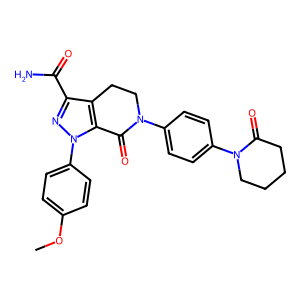

In [73]:
smile = ddi_labels.iloc[0]['interaction_drug_smiles']
m = Chem.MolFromSmiles(smile)
img = Chem.Draw.MolToImage(m)
img

In [74]:
def create_fingerprints(smiles_list, prefix):
    molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]
    fingerprint_arrays = [np.array(fingerprint) for fingerprint in fingerprints]
    res_df = pd.DataFrame({
        f'{prefix}_smiles': smiles_list,
        f'{prefix}_fingerprint': fingerprint_arrays
    })
    return res_df

In [ ]:
primary_fingerprint_df = create_fingerprints(ddi_labels['primary_smiles'].unique(), 'primary')
interaction_drug_fingerprint_df = create_fingerprints(ddi_labels['interaction_drug_smiles'].unique(), 'interaction_drug')

[18:56:56] Unusual charge on atom 0 number of radical electrons set to zero
[18:57:05] Unusual charge on atom 0 number of radical electrons set to zero


: 

In [ ]:
import ast
ddi_labels = pd.merge(ddi_labels, primary_fingerprint_df, how='left', on='primary_smiles')
ddi_labels = pd.merge(ddi_labels, interaction_drug_fingerprint_df, how='left', on='interaction_drug_smiles')

ddi_labels['concat_fingerprints'] = ddi_labels.apply(
    lambda row: np.concatenate([row['primary_fingerprint'], row['interaction_drug_fingerprint']]), axis=1
)
ddi_labels.head()

In [ ]:
ddi_labels.to_csv('data/ddi_labels_complete.csv')

In [ ]:
ddi_labels = pd.read_csv('data/ddi_labels_complete.csv')

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

/var/folders/9z/jvyz2w6d2v1bbg_kkfnms6m00000gn/T/ipykernel_4373/3279322215.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


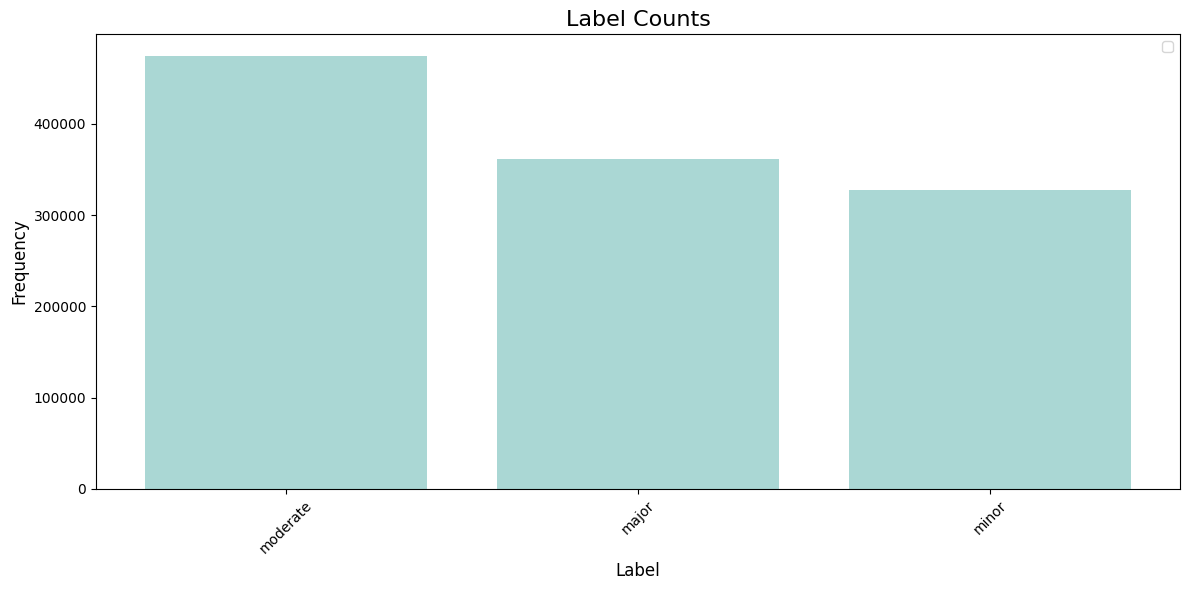

In [30]:
import matplotlib.pyplot as plt
label_counts = ddi_labels['label_meaning'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(label_counts.index, label_counts, color='#aad7d4')
plt.title('Label Counts', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
ddi_labels['concat_fingerprint'] = ddi_labels['concat_fingerprint'].apply(ast.literal_eval)
ddi_labels['len_fingerprints'] = ddi_labels['concat_fingerprints'].apply(
    lambda x: len(x)
)
ddi_labels['len_fingerprints'].unique()

KeyError: 'concat_fingerprint'

In [37]:
ddi_labels.iloc[0]['primary_fingerprint']

'[0 1 0 ... 0 0 0]'

In [33]:
features = np.array([np.array(fp) for fp in ddi_labels['concat_fingerprints']])
labels = ddi_labels['labels']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

class DDI_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DDI_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x